# Deep Dive Example: Robustness
## HopSkipJump Attack on ImageNet

We start with loading some basic libraries.

In [1]:
%matplotlib inline

import os

import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from art.estimators.classification import KerasClassifier

We then load the classifier.

In [2]:
mean_imagenet = np.zeros([224, 224, 3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)
model = ResNet50(weights='imagenet')
classifier = KerasClassifier(
    clip_values=(0, 255), 
    model=model, 
    preprocessing=(mean_imagenet, np.ones([224, 224, 3]))
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-06-15 10:33:53.711331: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-15 10:33:53.711364: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-15 10:33:53.711379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PF32XQKK): /proc/driver/nvidia/version does not exist
2022-06-15 10:33:56.697883: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-15 10:33:56.720459: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2304005000 Hz
2022-06-15 10:33:56.721697: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f67a0000b60 initialized for platform Host (this does not guarantee that X

We load the data now. Make sure to install [Imagenet Stubs](https://github.com/nottombrown/imagenet-stubs) before proceeding.

In [3]:
# data
import pandas as pd
import imagenet_stubs
from imagenet_2012_labels import label_to_name, name_to_label

all_paths = imagenet_stubs.get_image_paths()
all_imgs = []
for path in all_paths:
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    all_imgs.append(img)
all_names = [os.path.basename(path) for path in all_paths]
all_probs = [np.max(classifier.predict(np.array([img]))) for img in all_imgs]
all_labels = [np.argmax(classifier.predict(np.array([img]))) for img in all_imgs]

img_data = pd.DataFrame({
    'name': [os.path.splitext(name)[0] for name in all_names],
    'label': [label_to_name(label) for label in all_labels],
    'prob': [round(p,3) for p in all_probs], 
    'img': all_imgs}
).set_index('name')

Before proceeding, let us check the majority class probabilities for each image predicted by our classifier.

In [3]:
img_data[['label','prob']].sort_values(['prob']).reset_index()

,name,label,prob
0,malamute,"Eskimo dog, husky",0.494
1,beagle,beagle,0.530
2,standard_poodle,standard poodle,0.569
3,marmoset,"titi, titi monkey",0.623
4,tractor,tractor,0.791
5,notebook_computer,"notebook, notebook computer",0.893
6,sleeping_bag,sleeping bag,0.932
7,unicycle,"unicycle, monocycle",0.946
8,rock_crab,"rock crab, Cancer irroratus",0.980
9,flagpole,"flagpole, flagstaff",0.982


We define a function to obtain adversarial examples through iterative HopSkipJump attacks on an image. Then apply the function on a subset of our images. The second step takes a while, so we have precalculated the outputs (commented out) and stored them as a `.pkl` file which is loaded.

In [4]:
from art.attacks.evasion import HopSkipJump

# evaluation function
def evaluate_image(classifier, image, iter_step=10):
    attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10, verbose=False)
    x_adv = None
    norms = []
    adv_labels = []
    adv_names = []
    adv_imgs = []
    imgnorm = np.linalg.norm(np.reshape(image, [-1]))
    for i in range(5): # making this variable changes predictions!
        
        print("Step %d ->" % (i * iter_step), end=" ")
        x_adv = attack.generate(x=np.array([image]), x_adv_init=x_adv, resume=True)
        err = np.linalg.norm(np.reshape(x_adv[0] - image, [-1]))
        lab = np.argmax(classifier.predict(x_adv))
        nam = label_to_name(lab)
        print("L2 error", err, "and class label", lab, "/ name", nam)
    #     plt.imshow(x_adv[0].astype(np.uint))
    #     plt.show(block=False)
        attack.max_iter = iter_step
        norms.append(err)
        adv_labels.append(lab)
        adv_names.append(nam)
        adv_imgs.append(x_adv)
        
    df = pd.DataFrame({
        'absolute_distance': norms,
        'relative_distance': norms/imgnorm,
        'name': adv_labels,
        'label': adv_names,
        'image': adv_imgs
    })
    return df

In [5]:
import pickle
img_names = ['beagle','marmoset','standard_poodle','tractor','notebook_computer','sleeping_bag','koala']

# outputs = {}
# for nm in img_names:
#     img = img_data.loc[nm,'img']
#     print("Target image", nm)
#     if nm not in outputs.keys(): # avoid repeats
#         output_nm = evaluate_image(classifier, img)
#         outputs[nm] = output_nm
#     else:
#         print("skipped, already done")

# # save file
# handle = open('hsj_outputs.pkl', 'wb')
# pickle.dump(outputs, handle)
# handle.close()
f = open('hsj_outputs.pkl','rb')
outputs = pickle.load(f)
f.close()

The following code saves output images given in the chapter.

In [6]:
from matplotlib import pyplot as plt
from textwrap import wrap

def adv_plots(outputs, nm):
    all_adv = outputs[nm]['image']
    all_dist = outputs[nm]['absolute_distance']
    all_labs = outputs[nm]['label']

    plt.subplot(1, 3, 1)
    plt.imshow(img_data.loc[nm,'img'].astype(np.uint))
    plt.title('Original')
    orig_label = img_data.loc[nm,'label']
    plt.xlabel('Label: '+'\n'.join(wrap(orig_label, 35))) # wraps label

    plt.subplot(1, 3, 2)
    ind1 = 0
    plt.imshow(all_adv[ind1][0].astype(np.uint))
    plt.title('L2 error: '+str(round(all_dist[ind1],1)))
    plt.xlabel('Label: '+'\n'.join(wrap(all_labs[ind1], 35)))

    plt.subplot(1, 3, 3)
    ind2 = 4
    plt.imshow(all_adv[ind2][0].astype(np.uint))
    plt.title('L2 error: '+str(round(all_dist[ind2],1)))
    plt.xlabel('Label: '+'\n'.join(wrap(all_labs[ind2], 35)))

    return plt

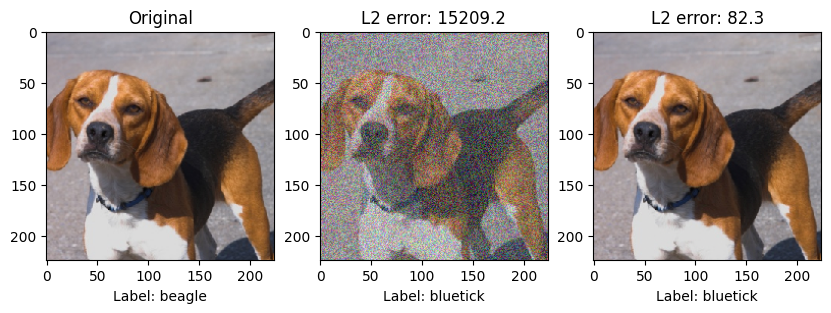

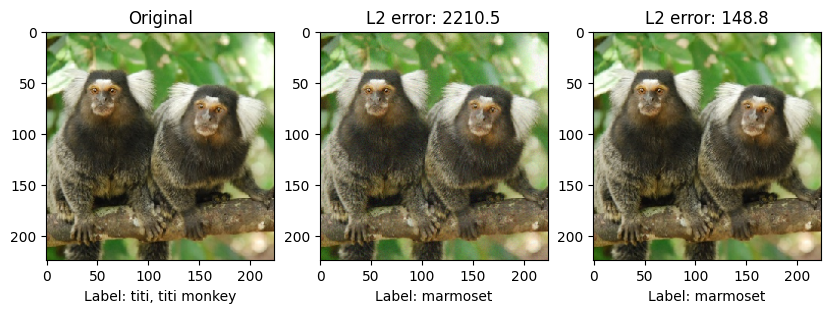

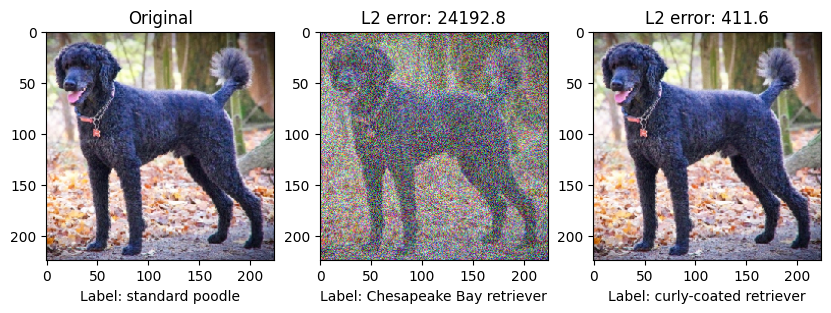

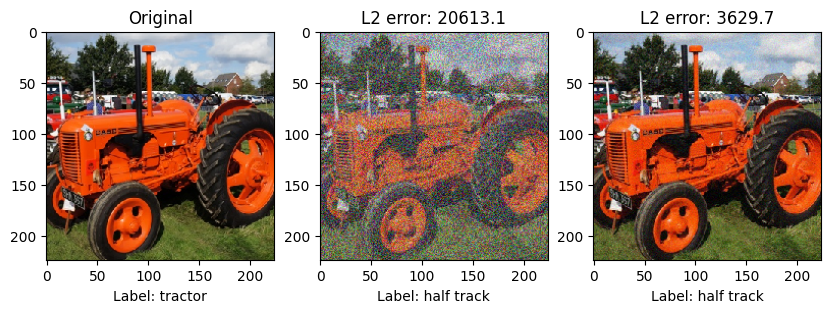

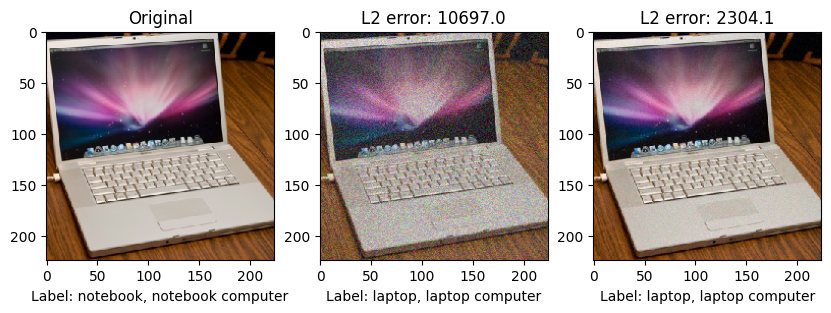

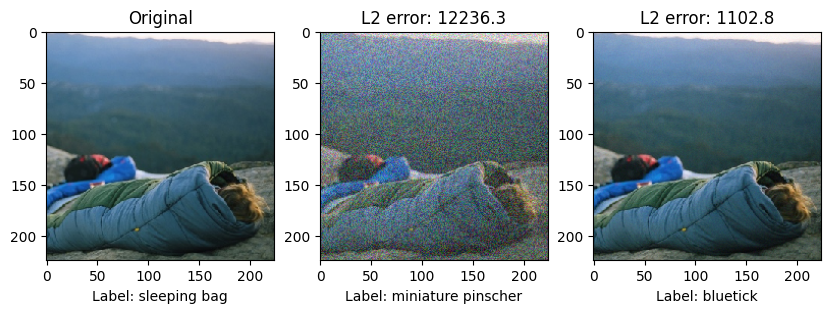

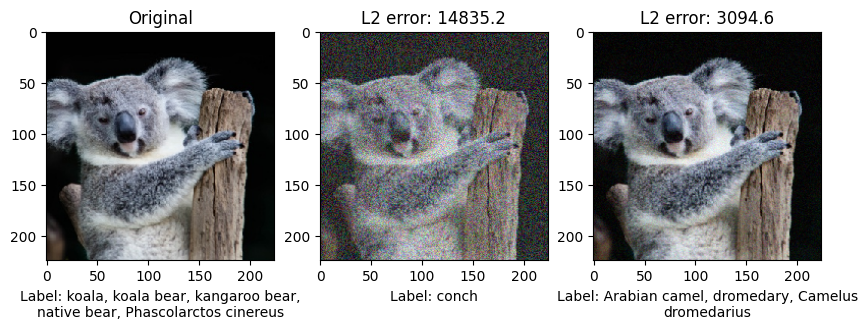

In [7]:
# save output images
for img in img_names:
    plt.figure(figsize=(10,15), dpi=100)
    plt = adv_plots(outputs, img)
    plt.ioff()
    plt.savefig('hsj_'+img+'.pdf', dpi=100, bbox_inches='tight')

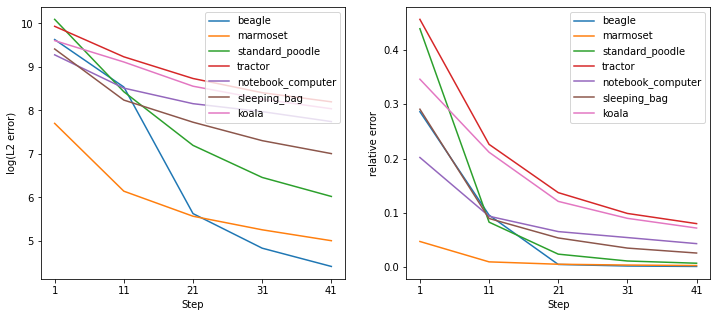

In [10]:
from math import log
plt.rcParams['figure.figsize'] = [12,5]
steps = np.arange(1,51, step=10)

plt.subplot(1, 2, 1)
for nm in img_names:
    plt.plot(steps, [log(a) for a in outputs[nm]['absolute_distance']], label=nm)
plt.xticks(steps)
plt.xlabel('Step')
plt.ylabel('log(L2 error)')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
for nm in img_names:
    plt.plot(steps, outputs[nm]['relative_distance'], label=nm)
plt.xticks(steps)
plt.xlabel('Step')
plt.ylabel('relative error')
plt.legend(loc='upper right')

# plt.show()
plt.savefig('hsj_plot.pdf', dpi=100, bbox_inches='tight')